## 0. Imports

In [16]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys,os
import argparse

#CAFPYANA working directory
CAFPYANA_WD = '/exp/sbnd/app/users/brindenc/develop/cafpyana'
os.environ['CAFPYANA_WD'] = CAFPYANA_WD

cafpyana_wd = os.environ.get('CAFPYANA_WD')
if cafpyana_wd and cafpyana_wd not in sys.path:
    sys.path.insert(0, cafpyana_wd)
    sys.path.insert(0, cafpyana_wd + '/pyanalib')

#My imports 
SBNDANA_DIR = '/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd'
sys.path.append(SBNDANA_DIR)
plt.style.use(f'{SBNDANA_DIR}/plotlibrary/numu2025.mplstyle')

from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.interaction import CAFInteraction
from sbnd.cafclasses.nu import NU
from sbnd.constants import *
from sbnd.numu.numu_constants import *
from sbnd.detector.definitions import * # >= v2.2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Constants

In [2]:
DATA_DIR = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both'
#parser = argparse.ArgumentParser()
# parser.add_argument('--fname','-f', type=str, required=True, help='name of the file to process (directory not included, its in the DATA_DIR in the script)')
# args = parser.parse_args()
# FNAME = args.fname
FNAME = 'mc_small.df'
APPLY_CUTS = False

print(f'File: {DATA_DIR}/{FNAME}')

File: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/mc_small.df


In [3]:
POT_DATA = 4.58e18 # This can also be found in header of data file
LIVETIME_DATAOFFBEAM = 1171346.0 #From medulla
LIVETIME_DATA = 9.51e5 # From medulla
POT_MC = pd.read_hdf(f'{DATA_DIR}/{FNAME}',key='hdr_0').pot.sum()

## 2. Post process

### 2.0 MCnu

In [45]:
mcnu = NU.load(f'{DATA_DIR}/{FNAME}',key='mcnu_0')

In [46]:
# Post process
mcnu.scale_to_pot(POT_DATA,sample_pot=POT_MC)

mcnu.add_fv()
mcnu.add_av()

mcnu.cut_muon(cut=APPLY_CUTS,min_ke=0.1)
mcnu.cut_fv(cut=APPLY_CUTS)
mcnu.cut_cosmic(cut=APPLY_CUTS)
mcnu.cut_cont(cut=APPLY_CUTS)

mcnu.add_event_type()

--scaling to POT: 7.51e+17 -> 4.58e+18
added key: cut.muon
added key: cut.fv
added key: cut.cosmic
added key: cut.cont


/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd/cafclasses/nu.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True False ... False  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.data.loc[:,cols[0]] = involume(self.data.position,volume=FV)
/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd/cafclasses/nu.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True False ... False  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.data.loc[:,cols[0]] = involume(self.data.position,volume=AV)


In [47]:
mcnu.data.event_type.value_counts()

event_type
3    9343
0    2088
5    1833
2    1253
1    1146
4      33
Name: count, dtype: int64

In [48]:
with open('mcnu_keys.txt','w') as f:
  for k in mcnu.data.keys():
    f.write(f'{k}\n')

### 2.1. Slice (Pandora)

In [28]:
slc = CAFSlice.load(f'{DATA_DIR}/{FNAME}', key='evt_pand_0', pot=POT_MC)

In [31]:
slc.clean(dummy_vals=[-9999,-999,999,9999,-5])

slc.scale_to_pot(POT_DATA,sample_pot=POT_MC)

slc.add_has_muon()
slc.add_in_av()
slc.add_in_fv()
slc.cut_cosmic(cut=APPLY_CUTS,fmatch_score=320,nu_score=0.5,use_opt0=True,use_isclearcosmic=True)
slc.cut_fv(cut=APPLY_CUTS)
slc.cut_muon(cut=APPLY_CUTS,min_ke=0.1)
slc.cut_is_cont(cut=APPLY_CUTS)

slc.add_event_type()

--scaling to POT: 7.51e+17 -> 4.58e+18
Number of clear cosmic: 57463
Cutting is clear cosmic
Cutting opt0 score: 320
Cutting nu score: 0.5
added key: cut.cosmic
added key: cut.truth.cosmic
added key: cut.fv
added key: cut.truth.fv
added key: cut.muon
added key: cut.truth.muon
added key: cut.cont
added key: cut.truth.cont


In [32]:
with open('slc_keys.txt','w') as f:
  for k in slc.data.keys():
    f.write(f'{k}\n')

In [38]:
slc.data.truth.event_type.value_counts(normalize=False)

event_type
6    69450
3     2863
1     1780
0     1370
2     1157
5      992
4       32
Name: count, dtype: int64

In [52]:
mcnu.data.index.names,slc.data.index.names

(FrozenList(['__ntuple', 'entry', 'rec.mc.nu..index']),
 FrozenList(['__ntuple', 'entry', 'rec.slc..index']))

In [59]:
_slc = slc.copy()
_slc.data = _slc.data.set_index(_slc.data.truth.ind, append=True).droplevel(-2)
_slc.data.index

MultiIndex([(0,    0, nan),
            (0,    0, 1.0),
            (0,    0, nan),
            (0,    0, nan),
            (0,    0, nan),
            (0,    0, nan),
            (0,    1, 1.0),
            (0,    1, nan),
            (0,    1, nan),
            (0,    1, nan),
            ...
            (0, 8693, nan),
            (0, 8693, nan),
            (0, 8693, nan),
            (0, 8694, 0.0),
            (0, 8694, nan),
            (0, 8694, nan),
            (0, 8694, nan),
            (0, 8694, nan),
            (0, 8694, nan),
            (0, 8694, nan)],
           names=['__ntuple', 'entry', 'ind'], length=77644)

In [49]:
PAND_CUTS = ['cosmic','fv','muon']
PAND_CUTS_CONT = PAND_CUTS + ['cont']
PAND_TRUTH_CUTS = ['cosmic','fv','muon']
PAND_TRUTH_CUTS_CONT = PAND_TRUTH_CUTS + ['cont']
pur,eff,f1 = slc.get_pur_eff_f1(mcnu,PAND_CUTS_CONT,PAND_TRUTH_CUTS_CONT,categories=[0,1])
pur,eff,f1

init_truth: 19725.19423991958, init_signal: 714750.3433758637, init_total: 17617801.79716684
cut: cosmic, truth_events: 19725.19423991958, signal_events: 540941.2122565268, total_events: 1064183.844581842
cut: fv, truth_events: 19725.19423991958, signal_events: 534814.7807418766, total_events: 702270.5754756501
cut: muon, truth_events: 19725.19423991958, signal_events: 461070.6976951603, total_events: 512124.2936505793
cut: cont, truth_events: 12735.375872897985, signal_events: 232577.4926857969, total_events: 256402.5041316591


(array([0.04056978, 0.50831557, 0.76155089, 0.90031015, 0.90707965]),
 array([1.        , 0.02759732, 0.02759732, 0.02759732, 0.01781794]),
 array([1.        , 0.05235234, 0.05326443, 0.05355307, 0.03494936]))

### 2.2. Interaction (SPINE)

In [9]:
inter = CAFInteraction.load(f'{DATA_DIR}/{FNAME}', key='evt_0', pot=POT_MC)

In [10]:
inter.clean(dummy_vals=[-9999,-999,999,9999,-5,np.inf,-np.inf])
inter.add_in_fv()
inter.add_in_av()

inter.scale_to_pot(POT_DATA,sample_pot=POT_MC)

inter.cut_cosmic(cut=APPLY_CUTS)
inter.cut_fv(cut=APPLY_CUTS)
inter.cut_muon(cut=APPLY_CUTS,min_ke=0.1)
inter.cut_is_cont(cut=APPLY_CUTS)
inter.cut_start_dedx(cut=APPLY_CUTS,dedx=3.5)
inter.cut_cosmic_score(cut=APPLY_CUTS,score=102.35)

inter.add_event_type()

--scaling to POT: 7.51e+17 -> 4.58e+18
added key: cut.cosmic
added key: cut.truth.cosmic
added key: cut.fv
added key: cut.truth.fv
added key: cut.muon
added key: cut.truth.muon
added key: cut.cont


/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd/cafclasses/particlegroup.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.data.loc[:, col] = condition


added key: cut.truth.cont
added key: cut.start_dedx
added key: cut.cosmic_score


In [11]:
with open('inter_keys.txt','w') as f:
  for k in inter.data.keys():
    f.write(f'{k}\n')

In [12]:
inter.data.truth.event_type.value_counts(normalize=False)

event_type
6    94949
3     3594
0     2853
5     2181
2     1636
1     1529
4       44
Name: count, dtype: int64

In [43]:
SPINE_CUTS = ['cosmic','fv','muon','start_dedx','cosmic_score']
SPINE_CUTS_CONT = ['cosmic','fv','muon','cont']
SPINE_TRUTH_CUTS = ['cosmic','fv','muon','','']
SPINE_TRUTH_CUTS_CONT = SPINE_CUTS_CONT.copy()
pur,eff,f1 = inter.get_pur_eff_f1(SPINE_CUTS,SPINE_TRUTH_CUTS,categories=[0,1])
pur,eff,f1

TypeError: get_pur_eff_f1() missing 1 required positional argument: 'truth_cuts'

In [ ]:
1/(len(inter.data)/len(slc.data))

0.727099057928942

### 2.3 Find exposure

In [ ]:
pot_mag = int(np.floor(np.log10(SAMPLE_POT_DATA)))
pot_base = SAMPLE_POT_DATA/10**pot_mag
POT_LABEL = f'{pot_base:.2f} x 10$^{{{pot_mag}}}$ POT'

## 3. Make plots as function of cut

## Testing

In [ ]:
inter.data.truth.E.isna().sum()

(94949, 0)

In [30]:
inter.data.truth.iscc.value_counts(),slc.data.iscc.value_counts()

(iscc
 1.0    9309
 0.0    2528
 Name: count, dtype: int64,
 iscc
 1.0    6630
 0.0    1141
 Name: count, dtype: int64)

In [39]:
run, subrun, evt = 3,12,23
inter.data.loc[inter.data.run == run,inter.data.subrun == subrun,inter.data.evt == evt].truth.loc[:,["pdg","event_type"]]

pdg event_type
                                              
                                              
                                              
                                              
__ntuple entry rec.dlp..index                 
0        2     0                NaN          6
               1               14.0          3
               2                NaN          6
               3                NaN          6
               4                NaN          6
               5                NaN          6
               6                NaN          6
               7                NaN          6
               8                NaN          6
               9               14.0          3
               10               NaN          6
               11              14.0          3
               12              14.0          3
               13               NaN          6

In [43]:
slc.data.loc[slc.data.run == run,slc.data.subrun == subrun,slc.data.evt == evt].truth.event_type

__ntuple  entry  rec.slc..index
0         2      0                 6
                 1                 6
                 2                 3
                 3                 6
                 4                 6
                 5                 6
                 6                 6
                 7                 6
                 8                 6
                 9                 3
Name: event_type, dtype: int64

In [34]:
inter.data.loc[inter.data.truth.iscc == 1,["run","subrun","evt"]].drop_duplicates(),slc.data.loc[slc.data.iscc == 1,["run","subrun","evt"]].drop_duplicates()


(                              run subrun  evt
                                              
                                              
                                              
                                              
                                              
 __ntuple entry rec.dlp..index                
 0        0     1                3     12    5
          1     3                3     12   19
          2     1                3     12   23
          3     12               3     12   25
          4     0                3     12   27
 ..                             ..    ...  ...
          8689  1               36     85   77
          8691  11              36     85   92
          8692  8               36     85   93
          8693  1               36     85   95
          8694  3               36     85  100
 
 [6768 rows x 3 columns],
                               run subrun  evt
                                              
                                

[[71271.   405.]
 [  846.  2821.]]


(<Figure size 700x500 with 2 Axes>,
 <Axes: xlabel='True class', ylabel='Predicted class'>)

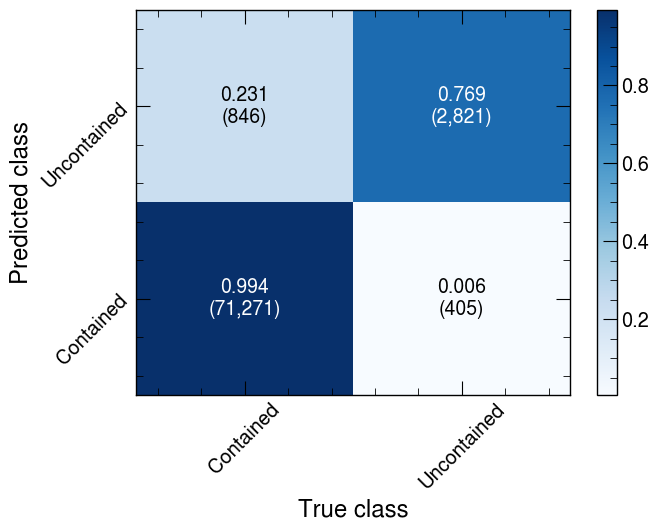

In [330]:
from sbnd.plotlibrary import makeplot
x = inter.data.mu.tpart.is_contained.values
y = inter.data.mu.is_contained.values

# x = inter.data.mu.is_primary
# y = inter.data.mu.truth.is_primary

hist = np.histogram2d(x,y,bins=[0,1,2])[0]
print(hist)

makeplot.draw_confusion_matrix_binned(hist,
class_names=['Contained','Uncontained'],
show_counts=True,
norm_ax=1
)

In [316]:
inter.data.truth.av.value_counts()
inter.data.truth.iscc.value_counts()
inter.data.truth.pdg.value_counts()

pdg
 14.0    11635
-14.0      124
 12.0       78
Name: count, dtype: int64

<Axes: >

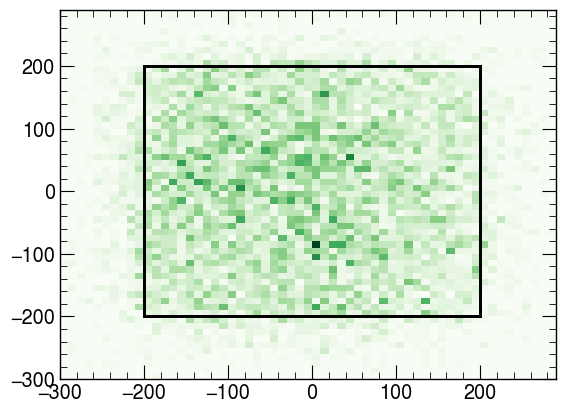

In [307]:
from sbnd.detector.volume import plot_volume_boundary

x = inter.data[~inter.data.truth.position.x.isna()].truth.position.x.values
y = inter.data[~inter.data.truth.position.y.isna()].truth.position.y.values

plt.hist2d(x,y,bins=np.arange(-300,300,10))
plot_volume_boundary(volume=AV,ax=plt.gca(),color='k')


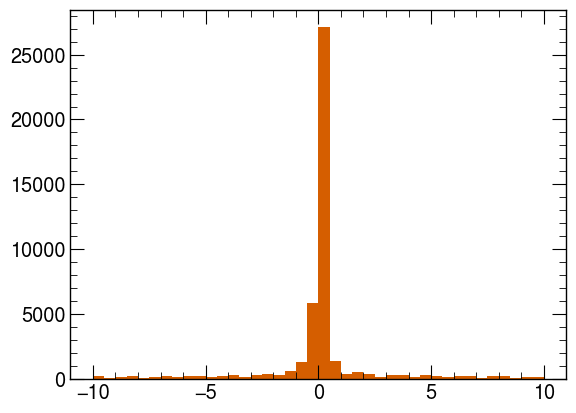

In [298]:
x = inter.data.mu.start_point.x
y = inter.data.mu.tpart.start_point.x

plt.hist(x-y,bins=np.arange(-10,10.5,0.5));

In [252]:
x.value_counts()

is_primary
1.0    81433
Name: count, dtype: int64

pid
2.0    81433
Name: count, dtype: int64

In [111]:
slc.data.mu.pfp.trk.truth.p.contained.value_counts()

contained
0.0    74
Name: count, dtype: int64

In [112]:
slc.data

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
0        0     0                            0   44.682514   85.553917   
               1                            0 -108.213371   82.100555   
               2                            0  140.860611 -199.704239   
               3                            0  166.353241   85.611969   
         1     0                            0 -200.000015 -150.731308   
..                                        ...         ...         ...   
         46    2                            0  161.198608  -50.728352   
         47    0                            0 -162.853439  111.342255   
               1                            0  157.174423  111.419601   
         48    0                            0  201.545013  -44.602688   
         49    0                            0 -123.812195   40.468098   

                                                                        \
                                          self tmatch         producer   
                                        z         eff pur idx            
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
__ntuple entry rec.slc..index                                            
0        0     0               415.433075   75    NaN NaN NaN        0   
               1               222.558105   76    NaN NaN NaN        0   
               2               152.417953   77    NaN NaN NaN        0   
               3               372.661713   74    NaN NaN NaN        0   
         1     0               274.906067   40    NaN NaN NaN        0   
..                                    ...  ...    ...  ..  ..      ...   
         46    2               505.262238   55    NaN NaN NaN        0   
         47    0               155.500870   56    NaN NaN NaN        0   
               1               301.480438   55    NaN NaN NaN        0   
         48    0               113.595673   91    NaN NaN NaN        0   
         49    0               143.710419   35    NaN NaN NaN        0   

                                             ... has_muon  truth vertex  \
                                       nuid  ...              av     av   
                              crlongtrkdiry  ...                          
                                             ...                          
                                             ...                          
                                             ...                          
                                             ...                          
                                             ...                          
__ntuple entry rec.slc..index                ...                          
0        0     0                  -0.564175  ...     True  False   True   
               1                  -0.812124  ...    False  False   True   
               2                  -0.205903  ...     True  False   True   
               3                  -0.288523  ...    False  False   True   
         1     0                  -0.431574  ...     True  False  False   
..                                      ...  ...  

In [333]:
hdr = pd.read_hdf(f'{DATA_DIR}/{FNAME}',key='hdr_0')
hdr.keys()

Index(['pot', 'first_in_subrun', 'ismc', 'run', 'subrun', 'ngenevt', 'evt',
       'proc', 'cluster', 'fno', 'noffbeambnb'],
      dtype='object')

In [336]:
from pyanalib.pandas_helpers import multicol_merge
multicol_merge(slc.data,hdr,left_index=True,right_index=True,how='left',validate='one_to_one')

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
0        0     0                            0  -93.493523 -144.838104   
               1                            0   53.705078   80.129021   
               2                            1 -127.981506  194.451080   
               3                            1  119.970314   55.909958   
               4                            1  -98.942528   18.080561   
..                                        ...         ...         ...   
         8694  2                            1 -192.610367  200.018951   
               3                            1   62.823784  193.182098   
               4                            1  -11.126747  204.403854   
               5                            1  -33.300854  -71.126671   
               6                            1  212.073074 -105.238426   

                                                                         \
                                          self    tmatch                  
                                        z            eff       pur  idx   
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
__ntuple entry rec.slc..index                                             
0        0     0                 3.480694   39       NaN       NaN  NaN   
               1               281.692993   38  0.849065  0.995891  1.0   
               2                 4.162482    1       NaN       NaN  NaN   
               3               330.043030    2       NaN       NaN  NaN   
               4                 2.862590    3       NaN       NaN  NaN   
..                                    ...  ...       ...       ...  ...   
         8694  2               107.239998    0       NaN       NaN  NaN   
               3               236.257477    1       NaN       NaN  NaN   
               4               405.795410    2       NaN       NaN  NaN   
               5                77.449585    3       NaN       NaN  NaN   
               6                 4.321503    4       NaN       NaN  NaN   

                                                      ... first_in_subrun  \
                              producer          nuid  ...                   
                                       crlongtrkdiry  ...                   
                                                      ...                   
                                                      ...                   
                                                      ...                   
                                                      ...                   
                                                      ...                   
__ntuple entry rec.slc..index                         ...                   
0        0     0                     0     -0.222321  ...               1   
               1                     0      0.200520  ...               1   
               2                     0           NaN  ...               1   
               3                     0           NaN  ...               1   
               4                     0           NaN  ...               1   
..

In [332]:
slc.data.head()

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
0        0     0                            0  -93.493523 -144.838104   
               1                            0   53.705078   80.129021   
               2                            1 -127.981506  194.451080   
               3                            1  119.970314   55.909958   
               4                            1  -98.942528   18.080561   

                                                                         \
                                          self    tmatch                  
                                        z            eff       pur  idx   
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
__ntuple entry rec.slc..index                                             
0        0     0                 3.480694   39       NaN       NaN  NaN   
               1               281.692993   38  0.849065  0.995891  1.0   
               2                 4.162482    1       NaN       NaN  NaN   
               3               330.043030    2       NaN       NaN  NaN   
               4                 2.862590    3       NaN       NaN  NaN   

                                                      ...        vertex  \
                              producer          nuid  ...  truth     av   
                                       crlongtrkdiry  ...     av          
                                                      ...                 
                                                      ...                 
                                                      ...                 
                                                      ...                 
                                                      ...                 
__ntuple entry rec.slc..index                         ...                 
0        0     0                     0     -0.222321  ...  False   True   
               1                     0      0.200520  ...   True   True   
               2                     0           NaN  ...  False   True   
               3                     0           NaN  ...  False   True   
               4                     0           NaN  ...  False   True   

                                 slc vertex    cut                       \
                               truth     fv cosmic     fv  truth   muon   
                                  fv                          fv          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
__ntuple entry rec.slc..index                                             
0        0     0               False  False  False  False  False   True   
               1                True   True   True   True   True   True   
               2               False  False  False  False  False  False   
               3 

In [76]:
slc.data.mu.pfp.trk.is_muon == True

__ntuple  entry  rec.slc..index
0         0      0                  True
                 1                 False
                 2                  True
                 3                 False
          1      0                  True
                                   ...  
          46     2                  True
          47     0                  True
                 1                  True
          48     0                  True
          49     0                 False
Name: is_muon, Length: 114, dtype: bool

In [23]:
h5name = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/mc_tiny.df'
h5df = pd.read_hdf(h5name,key='evt_pand_0')

In [24]:
list(h5df.keys())

[('slc', 'is_clear_cosmic', '', '', '', '', '', ''),
 ('slc', 'vertex', 'x', '', '', '', '', ''),
 ('slc', 'vertex', 'y', '', '', '', '', ''),
 ('slc', 'vertex', 'z', '', '', '', '', ''),
 ('slc', 'self', '', '', '', '', '', ''),
 ('slc', 'tmatch', 'eff', '', '', '', '', ''),
 ('slc', 'tmatch', 'pur', '', '', '', '', ''),
 ('slc', 'tmatch', 'idx', '', '', '', '', ''),
 ('slc', 'producer', '', '', '', '', '', ''),
 ('slc', 'nuid', 'crlongtrkdiry', '', '', '', '', ''),
 ('slc', 'nu_score', '', '', '', '', '', ''),
 ('slc', 'barycenterFM', 'flashTime', '', '', '', '', ''),
 ('slc', 'opt0', 'score', '', '', '', '', ''),
 ('slc', 'opt0', 'time', '', '', '', '', ''),
 ('slc', 'truth', 'E', '', '', '', '', ''),
 ('slc', 'truth', 'time', '', '', '', '', ''),
 ('slc', 'truth', 'bjorkenX', '', '', '', '', ''),
 ('slc', 'truth', 'inelasticityY', '', '', '', '', ''),
 ('slc', 'truth', 'Q2', '', '', '', '', ''),
 ('slc', 'truth', 'w', '', '', '', '', ''),
 ('slc', 'truth', 'momentum', 'x', '', '', 

In [57]:
fname = '/exp/sbnd/app/users/mueller/production/production_tools/official09082025/test.flat.root'
tree = uproot.open(fname)['recTree']
fkeys = [k for k in tree.keys() if "dlp" in k and '..' not in k]

In [59]:
df = tree.arrays(fkeys, library="pd")
list(df.keys())

['rec.dlp.cathode_offset',
 'rec.dlp.depositions_sum',
 'rec.dlp.flash_hypo_pe',
 'rec.dlp.flash_ids',
 'rec.dlp.flash_scores',
 'rec.dlp.flash_times',
 'rec.dlp.flash_total_pe',
 'rec.dlp.flash_volume_ids',
 'rec.dlp.id',
 'rec.dlp.is_cathode_crosser',
 'rec.dlp.is_contained',
 'rec.dlp.is_fiducial',
 'rec.dlp.is_flash_matched',
 'rec.dlp.is_matched',
 'rec.dlp.is_time_contained',
 'rec.dlp.is_truth',
 'rec.dlp.match_ids',
 'rec.dlp.match_overlaps',
 'rec.dlp.module_ids',
 'rec.dlp.num_particles',
 'rec.dlp.num_primary_particles',
 'rec.dlp.particle_counts.0',
 'rec.dlp.particle_counts.1',
 'rec.dlp.particle_counts.2',
 'rec.dlp.particle_counts.3',
 'rec.dlp.particle_counts.4',
 'rec.dlp.particle_counts.5',
 'rec.dlp.particle_ids',
 'rec.dlp.particles.axial_spread',
 'rec.dlp.particles.calo_ke',
 'rec.dlp.particles.cathode_offset',
 'rec.dlp.particles.chi2_per_pid.0',
 'rec.dlp.particles.chi2_per_pid.1',
 'rec.dlp.particles.chi2_per_pid.2',
 'rec.dlp.particles.chi2_per_pid.3',
 'rec.d

In [10]:
df = tree.arrays(fkeys + ['rec.dlp.id'], library="pd")
df.head()

,rec.dlp.flash_hypo_pe,rec.dlp.flash_ids,rec.dlp.flash_scores,rec.dlp.flash_times,rec.dlp.flash_total_pe,rec.dlp.flash_volume_ids,rec.dlp.is_flash_matched,rec.dlp.id
0,"[-1.0, -1.0, -1.0, -1.0, 8379.042642816883, -1...",[23 0],[989.6879272460938 989.6879272460938],[-0.706780731678009 -0.7034258246421814],"[-1.0, -1.0, -1.0, -1.0, 10880.831374999989, -...",[1 0],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
1,"[-1.0, -1.0, -1.0, -1.0, -1.0, 8904.7546602412...",[5 0],[716.545166015625 716.545166015625],[-0.6923614740371704 -0.6766427755355835],"[-1.0, -1.0, -1.0, -1.0, -1.0, 7313.1568000000...",[0 0],"[0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 1, 2, 3, 4, 5, 6, 7, 8]"
2,"[13092.910976158086, -1.0, -1.0, -1.0, -1.0, -...",[8 0],[1012.9766845703125 1012.9766845703125],[-0.7066944241523743 -0.7033153176307678],"[10859.815775000006, -1.0, -1.0, -1.0, -1.0, -...",[0 0],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,"[-1.0, -1.0, 18967.055757391903, -1.0, -1.0, -...",[14 0],[1068.540283203125 1068.540283203125],[-0.6963579058647156 -0.6779471635818481],"[-1.0, -1.0, 12843.913775000008, -1.0, -1.0, -...",[1 0],"[0, 0, 1, 0, 0, 0, 0]","[0, 1, 2, 3, 4, 5, 6]"
4,"[-1.0, -1.0, -1.0, 948.7943342085089, -1.0, -1...",[14 0],[7.7833709716796875 7.7833709716796875],[-1.2410569190979004 -1.2203258275985718],"[-1.0, -1.0, -1.0, 13945.097925000084, -1.0, -...",[1 0],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [22]:
import awkward as ak
ak.min(df.loc[:,'rec.dlp.flash_times'].values,axis=1)

<Array [-0.707, -0.692, -0.707, ..., -0.711, -0.712] type='50 * ?float64'>

In [25]:
fname_big = '/pnfs/sbnd/scratch/users/mueller/mc5e18_bugfix_v2/flat/input000.flat.root'
glob_tree = uproot.open(fname_big)['globalTree']
glob_tree.keys()

['global',
 'global/wgts',
 'global/wgts/wgts.name',
 'global/wgts/wgts.type',
 'global/wgts/wgts.nuniv',
 'global/wgts/wgts.covmx',
 'global/wgts/wgts.map']

In [5]:
ind = 6
[(name,len(df.iloc[ind].values[i])) for i,name in enumerate(df.columns)]

TypeError: object of type 'numpy.int32' has no len()